# Direct detection of dark matter

In this notebook, we will calculate the event rate for dark matter scattering off of nuclei, as would be expected in dark matter direct detection experiments. We will use this to look at the expected sensitivity of such experiments for a variety of target materials and experimental configurations.

References:
- [Lectures on Dark Matter Physics -- Mariangela Lisanti](https://arxiv.org/abs/1603.03797)
- [Supersymmetric dark matter -- Jungman et al.](https://www.sciencedirect.com/science/article/pii/0370157395000585)

Note that these references are geared for beginning graduate students; you are certainly not expected to know everything there!

<img src="NucRecoilAtoms.jpg">

In [2]:
# All imports should be on top of the notebook

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import scipy

from scipy import special

## 0. Units and constants

We define our units upfront here.  Our convention will be to use natural units throughout.  For simplicity, we will define the SI units in terms of their corresponding natural units here.  Later in the notebook, you can define a quantity in terms of its SI unit and the conversion to natural units happens 'automatically.'

As convention, we take keV $=1$ as the base unit.  Therefore:

In [3]:
GeV = 1e6  # GeV = 1e6 * keV = 1e6 when keV = 1
eV = 1e-9*GeV
keV = 1e-6*GeV
MeV = 1e-3*GeV

We will do our calculations in natural units, assuming  ℏ=c=1.  Make sure that you understand the definitions in the block below.  They are derived using the following relations:

$$
c = 2.99792*10^5~\mathrm{ km/s} 
$$

$$
\frac{1~\mathrm{GeV}}{c^2} = 1.79 * 10^{-27}~\mathrm{kg}
$$

$$
ℏc = 1.97 * 10^{-14}~\mathrm{GeV}~\mathrm{cm} 
$$

$$
ℏ = 6.58*10^{-25}~\mathrm{GeV}~\mathrm{s}
$$

In [4]:
Kmps = 3.3e-6   # km/s
Kg = 5.6e35*eV  # kg
Sec = 1/(6.58e-16*eV)  #seconds
amu = 1.66e-27*Kg   # atomic mass unit in kg
Centimeter = 5.07e13/GeV  # cm

The rate per target mass has units of counts/kg/s.  It will be more convenient to quote results in terms of counts/kg/days and counts/kg/years, as defined here:

In [5]:
KgDay = Kg*Sec*86400   
KgYear = 365.25*KgDay

In the following, it will be easiest if you keep track of units in the variable definitions.  For example, to define a velocity with units of km/s, one would use

$$
v = \mathrm{(some~number)} * \mathrm{Kmps}
$$

## 1. Direct detection event rate

Direct detection experiments aim to observe a dark matter particle recoiling off a nucleus following some mutual interaction. See Section II of https://arxiv.org/pdf/1209.3339.pdf for more details on the direct detection formalism. For the most common types of interactions, the differential event rate (per unit detector mass and nuclear recoil energy $E_\mathrm{nr}$) takes the form

$$  \frac{dR}{dE_\mathrm{nr}}
    = \frac{1}{2 m_\mathrm{DM} \mu_N^2} \, \sigma_N \, \rho_\mathrm{DM} \eta(v_\mathrm{min}(E_\mathrm{nr}),t),
    $$

where $\mu_N$ is the dark matter-nucleus reduced mass, $m_\mathrm{DM}$ is the dark matter mass, $\rho_\mathrm{DM}$ is the dark matter density, $\sigma_N$ is an effective scattering cross-section describing the interaction between the dark matter and nucleus and

$$\eta(v_\mathrm{min},t) = \int_{v > v_\mathrm{min}} d^3v \, \frac{f(\mathbf{v + v}_\mathrm{obs}(t))}{v}$$
is the mean inverse speed, with

$$
  v_\mathrm{min} =
      \sqrt{\frac{m_N E_\mathrm{nr}}{2\mu_N^2}}
$$

the minimum DM velocity needed to induce a recoil for the case of elastic scattering. Note that $f(\mathbf{v})$ is the assumed Galactic-frame DM distribution, and $v_\mathrm{obs}(t)$ takes into account the motion of the Sun and Earth -- $(\mathbf{v + v}_\mathrm{obs}(t))$ is the boosted DM velocity in the lab frame, which is relevant for direct detection experiments.

Writing the event rate in this form, we can separate out the astrophysical component of the rate $\rho_\mathrm{DM} \eta(v_\mathrm{min}(E_\mathrm{nr}),t)$ and the particle physics component $\sigma_N$. We will now implement these one at a time.

### Astrophysics

Here, you will define the functions that are needed to calculate $\eta$ for one possible velocity distribution function.  Start by defining functions to calculate:
- The reduced mass of two particles $\mu(m_1, m_2)$
- The minimum DM velocity to induce recoil, $v_\mathrm{min}(E_\mathrm{nr}, m_\mathrm{DM}, m_N)$

In [6]:
def red_mass(m1, m2):
  mu_n = (m1*m2)/(m1+m2)
  return mu_n

def v_min(E, m_dm, m_n):
  mu_n = red_mass(m_n,m_dm)
  v_min = np.sqrt(np.divide(np.multiply(m_n,E),(2*mu_n**2)))
  return v_min

Next, define the function to calculate the velocity integral  $\eta(v_\mathrm{min})$.  For now, assume a simple Maxwellian velocity distribution: 

$$
 f(\mathbf v) =
       \left( \frac{1}{\pi v_0^2} \right)^{3/2}
        \, e^{-\mathbf v^2\!/v_0^2} 
$$

with $v_0 ≈ 220$ km/s the most probable Galactic-frame dark matter velocity. If we approximate the escape velocity to be infinite, then the velocity integral can be performed analytically.  The result is

$$
\eta(v_\mathrm{min}) = \frac{1}{2 v_\mathrm{obs}} \Big[ \mathrm{erf}(x+y) - \mathrm{erf}(x-y) \Big] ,
$$

where $x \equiv v_\mathrm{min}/v_0$ and $y = v_\mathrm{obs}/v_0$.  Take the Galactic-frame Earth speed to be time independent at $v_\mathrm{obs} \approx 250$ km/s .  Documentation on the error function can be found here:
https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.special.erf.html


In [7]:
v_obs = 250*Kmps
v_0 = 220*Kmps
def get_integral(v_min):
  x = np.divide(v_min,v_0)
  y = v_obs/v_0
  integral = (1/(2*v_obs))*(special.erf(x+y)-special.erf(x-y))
  return integral

### Particle physics

We now define a few nuclear parameters. To compare rates and sensitivities across different experiments using different target nuclei, it is useful to define the DM-nucleon (in our case, DM-proton) cross-section and present results in terms of this. To convert between the DM-nucleus and DM-nucleon cross section, use the following:

$$
\sigma_\mathrm{N} = \frac{\mu_N^2}{\mu^2_p}A^2\sigma_p
$$

where $\mu_N$ is the DM-nucleus reduced mass, $\mu_p$ the DM-proton reduced mass, and $A$ is the atomic mass number (equal to the number of protons and neutrons). 

Write a function that yields $\sigma_\mathrm{N}$ for a given value of $\sigma_p$ and target material.  Define the proton mass to be 1 atomic mass unit--remember to account for units in your variable definition.

In [8]:
m_p = 1*amu

def sigma_n(sigma_p, m_n, m_dm, A):
  mu_p = red_mass(m_p,m_dm)
  mu_n = red_mass(m_n, m_dm)
  sigma_n = ((mu_n**2)/(mu_p**2))*(A**2)*(sigma_p)
  return sigma_n

Note that we've not account for the momentum-transfer-dependent form factor $F(q)$, so our estimates are likely to be somewhat optimistic.

### Event rate

Write a function that calculates the differential scatering rate $dR/dE_\mathrm{nr}$ as a function of nuclear recoil energy, dark matter mass, nuclear mass, and $\sigma_p$.

$$  \frac{dR}{dE_\mathrm{nr}}
    = \frac{1}{2 m_\mathrm{DM} \mu_N^2} \, \sigma_N \, \rho_\mathrm{DM} \eta(v_\mathrm{min}(E_\mathrm{nr}),t),
    $$



Take the local dark matter density to be $\rho_\mathrm{DM} = 0.4$ GeV/cm$^3$. Again, write out all units explicitly in your variable definitions, referencing Sec. 0.


In [9]:
"""
p_dm = 0.4*GeV*Centimeter**(-3)

def dRdE(m_dm, p_dm, sigma_n, mu_n, n):
  dRdE = (1/(2*m_dm*mu_n**2))*(sigma_n*p_dm*n)
  return dRdE
"""

In [10]:
p_dm = 0.4*GeV*Centimeter**(-3)

def dRdE1(m_dm, m_n, sigma_p, A, E):
  vmin = v_min(E, m_dm, m_n)
  c = (1/(2*m_dm*red_mass(m_n,m_dm)**2))
  dRdE = c*(sigma_n(sigma_p, m_n, m_dm, A)*p_dm*get_integral(vmin))
  return dRdE

For concreteness, consider a 100 GeV mass dark matter particle scattering off of a Xenon nucleus.  Assume that $\sigma_p = 10^{-45}$ cm$^2$, which is roughly in the range of what you would expect for Higgs-mediated processes.  

Plot the differential scattering rate as a function of nuclear recoil energy $E_\mathrm{nr}$, taking values from 0 to 75 keV.  Note that your differential rate function will be outputting a quantity in natural units.  To convert this to counts/kg/year/keV, multiply by KgYear*keV.

In [11]:
m_dm = 100*GeV
sigmap = 10**-45*Centimeter**(2)
A = 54
m_n = 131.293*amu

mu_n = red_mass(m_n, m_dm)

Enr = np.linspace(0,75,75)
vmin = v_min(Enr, m_dm, m_n)
n = get_integral(vmin)
sigman = sigma_n(sigmap,m_n,m_dm,A)
drde = dRdE(m_dm,p_dm, sigman, mu_n,n)*KgYear*keV

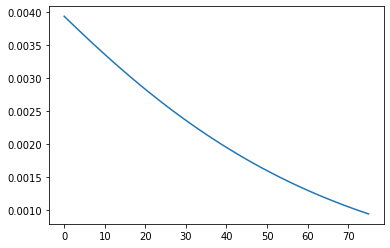

In [12]:
plt.plot(Enr, drde)

In [13]:
m_dm = 100*GeV
sigmap = 10**-45*Centimeter**(2)
A = 54
m_n = 131.293*amu
Enr = np.linspace(0,75,75)

drde_v = dRdE1(m_dm,m_n,sigmap,A,Enr)*KgYear
drde_1 = dRdE1(30*GeV,m_n,sigmap,A,Enr)*KgYear
drde_2 = dRdE1(50*GeV,m_n,sigmap,A,Enr)*KgYear
drde_3 = dRdE1(10*GeV,m_n,sigmap,A,Enr)*KgYear
drde_4 = dRdE1(500*GeV,m_n,sigmap,A,Enr)*KgYear

Text(0, 0.5, 'Differential Scattering rate')

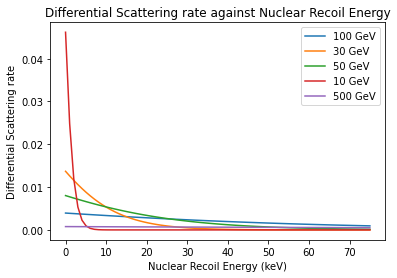

In [14]:
plt.plot(Enr, drde_v, label = '100 GeV')
plt.plot(Enr, drde_1, label = '30 GeV')
plt.plot(Enr, drde_2, label = '50 GeV')
plt.plot(Enr, drde_3, label = '10 GeV')
plt.plot(Enr, drde_4, label = '500 GeV')
plt.legend()
plt.title("Differential Scattering rate against Nuclear Recoil Energy")
plt.xlabel("Nuclear Recoil Energy (keV)")
plt.ylabel("Differential Scattering rate")

Compare the scattering rates for different dark matter masses: $m_\mathrm{DM} = 10, 30, 50, 100, 500$ GeV.

In [117]:
"""
m_dm1 = 10*GeV
mu_n1 = red_mass(m_n, m_dm1)
vmin1 = v_min(Enr, m_dm1, m_n)
n1 = get_integral(vmin1)
sigman1 = sigma_n(sigmap,mu_n1,m_dm1,A)
drde1 = dRdE(m_dm1,p_dm, sigman1, mu_n1,n)*KgYear*keV

m_dm2 = 30*GeV
mu_n2 = red_mass(m_n, m_dm2)
vmin2 = v_min(Enr, m_dm2, m_n)
n2 = get_integral(vmin2)
sigman2 = sigma_n(sigmap,mu_n2,m_dm2,A)
drde2 = dRdE(m_dm2,p_dm, sigman2, mu_n2,n)*KgYear*keV

m_dm3 = 50*GeV
mu_n3 = red_mass(m_n, m_dm3)
vmin3 = v_min(Enr, m_dm3, m_n)
n3 = get_integral(vmin3)
sigman3 = sigma_n(sigmap,mu_n3,m_dm3,A)
drde3 = dRdE(m_dm3,p_dm, sigman3, mu_n3,n)*KgYear*keV

m_dm4 = 500*GeV
mu_n4 = red_mass(m_n, m_dm4)
vmin4 = v_min(Enr, m_dm4, m_n)
n4 = get_integral(vmin4)
sigman4 = sigma_n(sigmap,mu_n4,m_dm4,A)
drde4 = dRdE(m_dm4,p_dm, sigman4, mu_n4,n)*KgYear*keV
"""


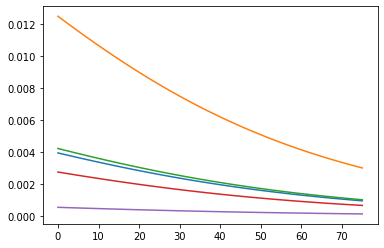

In [118]:
"""
plt.plot(Enr, drde)
plt.plot(Enr, drde1)
plt.plot(Enr, drde2)
plt.plot(Enr, drde3)
plt.plot(Enr, drde4)
"""